#### 设置环境

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

#### 导入数据集

In [2]:
n_epochs = 15
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
compose = transforms.Compose([
        # transforms.Resize(28),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomCrop(28),
        # transforms.ColorJitter(brightness=1, contrast=0.1, hue=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
])
torch.manual_seed(random_seed)


In [3]:
train_loader = DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True, transform=compose),
                                batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True, transform=compose),
                                batch_size=batch_size_test, shuffle=True)


    函数&参数讲解：
        DataLoader函数的作用是将输入的数据集打包分组
        bath_sizer参数为每组大小
        shuffle为是否打乱数据（建议选True）
        transfrom以图片修改函数为参数
        Compose是图片修改函数
        ToTensor将图片转换为张量(Tensor)
        Normalize为将输入标准正态化

#### 查看数字标签

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets)
print(example_data.shape)


tensor([3, 9, 4, 9, 9, 0, 8, 3, 1, 2, 3, 9, 1, 3, 6, 6, 4, 4, 9, 7, 3, 7, 6, 3,
        4, 8, 4, 6, 8, 6, 1, 1, 1, 1, 0, 0, 1, 8, 4, 0, 1, 2, 7, 9, 3, 2, 3, 8,
        3, 2, 0, 4, 6, 6, 5, 5, 3, 0, 3, 7, 2, 4, 1, 6, 7, 5, 4, 1, 0, 8, 5, 9,
        0, 9, 6, 1, 8, 0, 9, 3, 5, 7, 8, 5, 6, 4, 2, 2, 2, 1, 8, 4, 4, 2, 1, 5,
        9, 3, 7, 0, 4, 1, 7, 2, 2, 6, 5, 1, 2, 6, 1, 3, 1, 2, 7, 4, 1, 3, 2, 9,
        3, 7, 2, 7, 4, 7, 0, 0, 9, 0, 9, 5, 1, 6, 9, 8, 1, 4, 6, 7, 5, 5, 6, 4,
        5, 4, 0, 7, 4, 1, 3, 8, 2, 6, 2, 2, 8, 4, 1, 9, 6, 7, 5, 0, 7, 4, 6, 2,
        6, 8, 7, 9, 8, 0, 7, 4, 2, 4, 9, 0, 4, 6, 5, 6, 6, 4, 4, 8, 3, 8, 0, 9,
        5, 6, 3, 3, 8, 4, 4, 6, 7, 8, 5, 3, 4, 3, 3, 3, 3, 1, 8, 8, 9, 1, 0, 1,
        4, 1, 0, 2, 0, 6, 5, 1, 5, 8, 8, 1, 3, 9, 4, 5, 9, 2, 5, 6, 5, 8, 2, 7,
        4, 1, 6, 8, 7, 9, 3, 3, 4, 4, 5, 4, 9, 8, 2, 9, 1, 6, 7, 1, 0, 5, 1, 9,
        2, 1, 5, 2, 7, 9, 0, 0, 6, 0, 8, 7, 2, 6, 1, 7, 6, 1, 2, 1, 6, 3, 1, 4,
        1, 7, 5, 9, 3, 8, 6, 3, 8, 7, 4,

#### 查看数据集

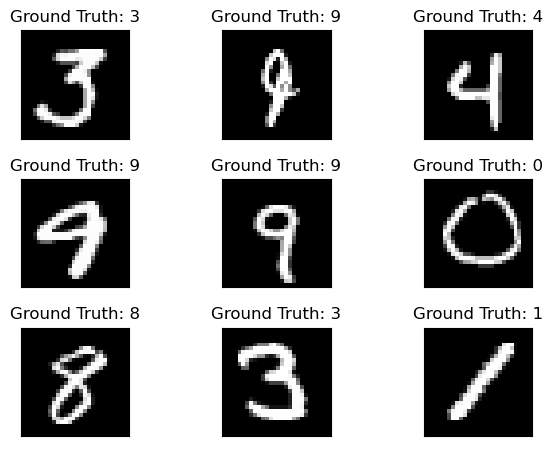

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


#### 构建网络

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.dense1 = nn.Linear(320, 50)
        self.dense2 = nn.Linear(50, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2_drop(self.conv2(x))))
        x = x.view(-1, 320)
        x = self.relu(self.dense1(x))
        x = F.dropout(x, training=self.training)
        x = self.dense2(x)
        return self.softmax(x)


network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
print(network.parameters())

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')


# train(1)


def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='mean').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


test()  # 不加这个，后面画图就会报错：x and y must be the same size
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


<generator object Module.parameters at 0x7f7e19850b30>

Test set: Avg. loss: 0.0023, Accuracy: 860/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316370
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.304416
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.306078
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.297958
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.278291
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.298741
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.271414
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.271428
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.272656
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.256520
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.234972
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.219309
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.230059
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.206300
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.158024
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.102299
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.047887
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.117776
Train Epoch: 1 [11

#### 性能评估

[0.002307049870491028, 0.00022575203776359557, 0.00013432946428656577, 0.00010905693620443344, 9.324985668063164e-05, 8.096039146184921e-05, 7.452929764986038e-05, 6.802910380065441e-05, 6.591175235807895e-05, 5.9619414806365966e-05, 5.544069223105907e-05, 5.6806670874357225e-05, 5.601362325251102e-05, 5.197502039372921e-05, 4.915082398802042e-05, 4.809762686491012e-05]


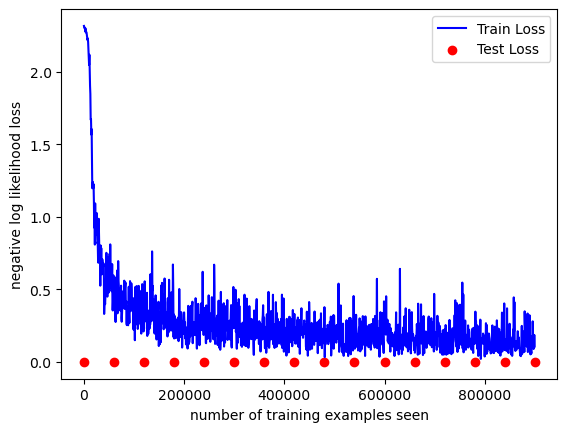

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
print(test_losses)
plt.show()
